In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score


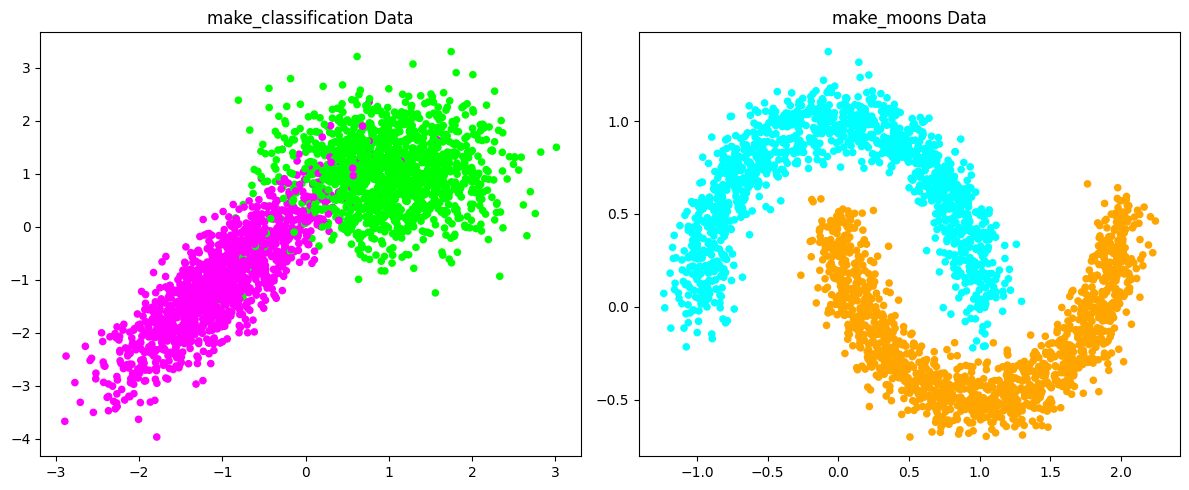

In [48]:
random_state=254493
n_samples = 2593

X_clf, t_clf = make_classification(random_state=random_state, n_samples=n_samples, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1)

X_moons, t_moons = make_moons(random_state=random_state, n_samples=n_samples, noise=0.1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_clf[:, 0], X_clf[:, 1], c=np.where(t_clf==0, 'lime', 'magenta'), s=20)
plt.title('make_classification Data')

plt.subplot(1, 2, 2)
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=np.where(t_moons==0, 'cyan', 'orange'), s=20)
plt.title('make_moons Data')

plt.tight_layout()
plt.show()


Dzieleie na dane testowe i treningowe


In [49]:
X_train_clf, X_test_clf, t_train_clf, t_test_clf = train_test_split(X_clf, t_clf, test_size=0.2, random_state=random_state)

In [50]:
X_train_moons, X_test_moons, t_train_moons, t_test_moons = train_test_split(X_moons, t_moons, test_size=0.2, random_state=random_state)

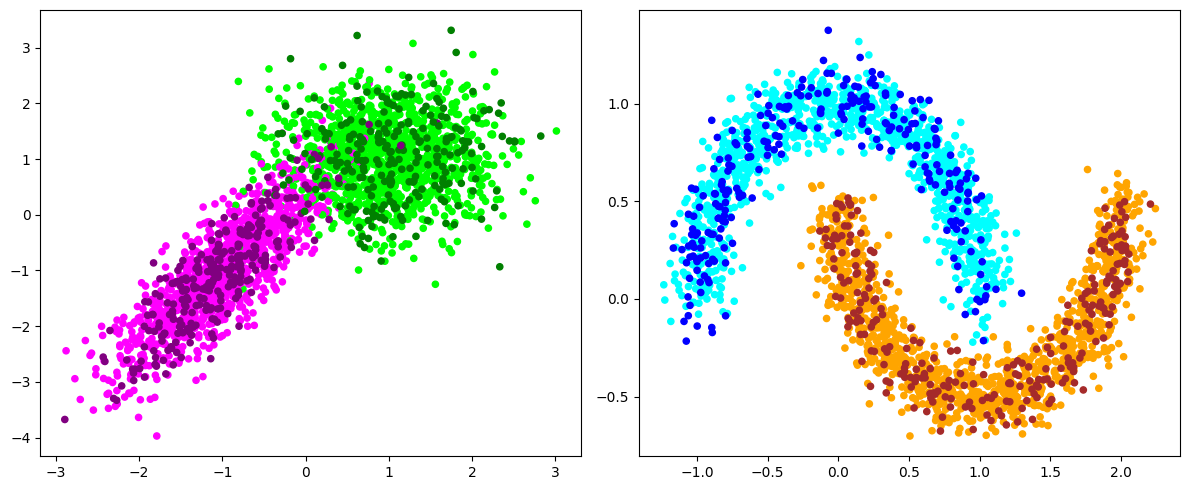

In [51]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_clf[:, 0], X_train_clf[:, 1], c=np.where(t_train_clf==0, 'lime', 'magenta'), s=20)
plt.scatter(X_test_clf[:, 0], X_test_clf[:, 1], c=np.where(t_test_clf==0, 'green', 'purple'), s=20)


plt.subplot(1, 2, 2)
plt.scatter(X_train_moons[:, 0], X_train_moons[:, 1], c=np.where(t_train_moons==0, 'cyan', 'orange'), s=20)
plt.scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=np.where(t_test_moons==0, 'blue', 'brown'), s=20)

plt.tight_layout()
plt.show()


In [52]:
X1 = np.array(X_train_clf[t_train_clf == 1])
X2 = np.array(X_train_clf[t_train_clf == 0])
X = np.vstack((X1,X2))
X = np.c_[X, np.ones(X.shape[0])]
t = np.ones(X.shape[0])
t[:X1.shape[0]] *= -1

In [53]:
def linear_function(Theta, variable):
    return (-Theta[0]*variable-Theta[2])/Theta[1]

In [54]:
Theta = np.linalg.inv(X.T@X + 0.05*np.eye(X.shape[1]))@X.T@t
print(Theta)
x = np.linspace(np.min(X1[:,0]), np.max(X2[:,1]),100)

[0.53095841 0.2007859  0.0062573 ]


In [55]:
def classify_sample(Theta, test_sample):
    x = test_sample[0]
    y = test_sample[1]
    label = test_sample[2]
    function = linear_function(Theta, x)
    if y < function:
        return [[x,y], [label, -1]]
    return [[x,y], [label, 1]]

In [56]:
def classify(Theta, x_test):
    X = []
    for x in x_test:
        result_of_classification = classify_sample(Theta, x)
        X.append([result_of_classification[0], result_of_classification[1], result_of_classification[1][0] == result_of_classification[1][1]])
    return sorted(X, key=lambda v: not v[2])

In [57]:
X_test = [[X_test_clf[i][0], X_test_clf[i][1], -2*t_test_clf[i]+1] for i in range(len(X_test_clf))]
X_res = classify(Theta, X_test)

In [58]:
def plot_classification_result(X_result, Theta, lin_color, c1, c2, variable, xmin, xmax, ymin, ymax, title):
    fig, ax = plt.subplots()
    plt.plot(variable,linear_function(Theta, variable), color=lin_color)
    plt.title(title)
    plt.fill_between(variable, linear_function(Theta, variable), max(linear_function(Theta, variable)), color = c2, alpha=0.2)
    plt.fill_between(variable, linear_function(Theta, variable), min(linear_function(Theta, variable)), color = c1, alpha=0.2)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    for x in X_result:
        
        if x[1][0] == -1:
            color = c1
            bordercolor = c1
        else:
            color = c2
            bordercolor = c2

        if not x[2]:
            bordercolor = 'b'
        plt.scatter(x[0][0], x[0][1], color=color, edgecolor=bordercolor)


In [59]:
def plot_confusion_matrix(true_labels, predicted_labels, cmap):
    cm = confusion_matrix(true_labels, predicted_labels)

    sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # Czułość (True Positive Rate)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Swoistość (True Negative Rate)
    accuracy = (cm[0, 0] + cm[1, 1]) / cm.sum()  # Dokładność (Accuracy)

    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(cm, annot=True, cmap=cmap, fmt="d", xticklabels=['Actual -1', 'Actual 1'],
                     yticklabels=['Predicted -1', 'Predicted 1'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')

    text = f'Sensitivity: {sensitivity:.5f}\nSpecificity: {specificity:.5f}\nAccuracy: {accuracy:.5f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(1.2, 0.5, text, transform=ax.transAxes, fontsize=12, verticalalignment='center', bbox=props)

    plt.show()

In [60]:
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]

In [61]:
def plot_ROC(true_labels, predicted_labels):
    fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkgreen', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.fill_between(fpr, tpr, color='yellow', alpha=0.3)  # Jasnożółta powierzchnia pod krzywą
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

In [62]:
def plot_classification_summary(true_labels, predicted_labels, cmap):
    plot_confusion_matrix(true_labels, np.sign(predicted_labels), cmap)
    plot_ROC(true_labels, predicted_labels)

Wyniki analitycznej klasyfikacji liniowej

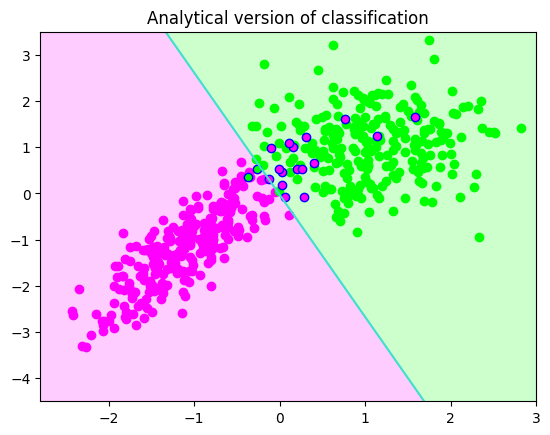

In [63]:
plot_classification_result(X_res, Theta, 'turquoise', 'magenta', 'lime', x, -2.8,3,-4.5,3.5, 'Analytical version of classification')

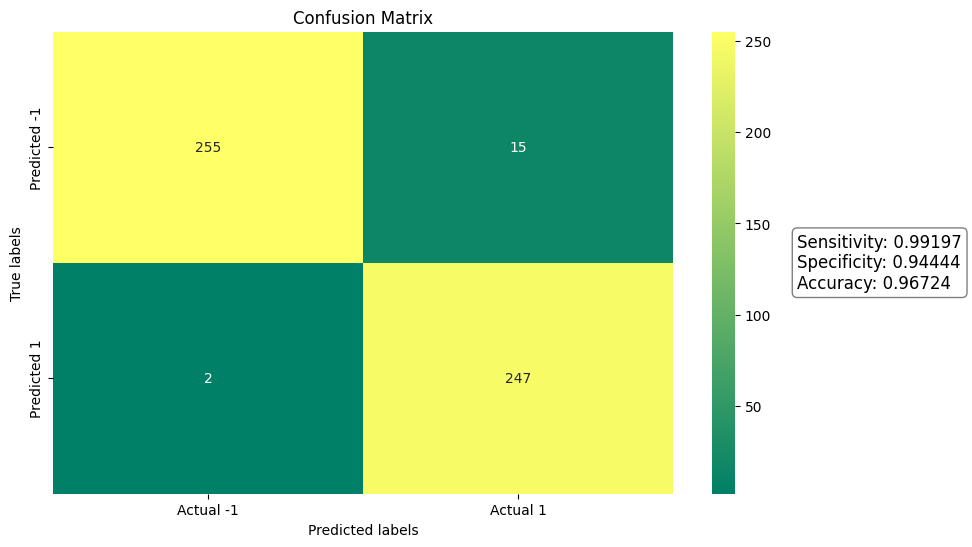

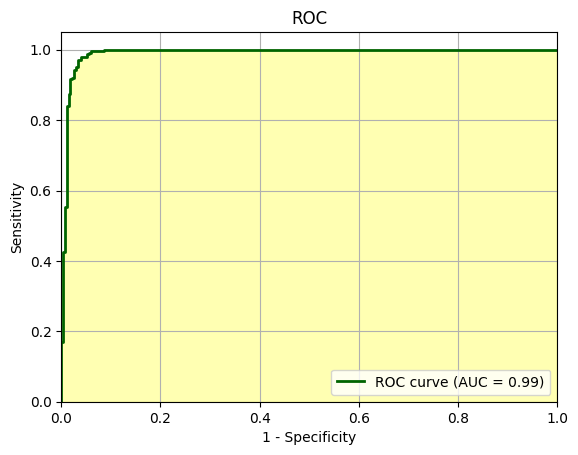

In [64]:
plot_classification_summary(true_labels, predicted_labels, 'summer')

In [65]:
X1 = np.array(X_train_moons[t_train_moons == 1])
X2 = np.array(X_train_moons[t_train_moons == 0])
X = np.vstack((X1,X2))
X = np.c_[X, np.ones(X.shape[0])]
t = np.ones(X.shape[0])
t[:X1.shape[0]] *= -1

Theta = np.linalg.inv(X.T@X+0.15*np.eye(X.shape[1]))@X.T@t
print(Theta)
x = np.linspace(-15, 25, 400)
X_test = [[X_test_moons[i][0], X_test_moons[i][1], -2*t_test_moons[i]+1] for i in range(len(X_test_moons))]
X_res = classify(Theta, X_test)
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]

[-0.31410525  1.28976843 -0.15976921]


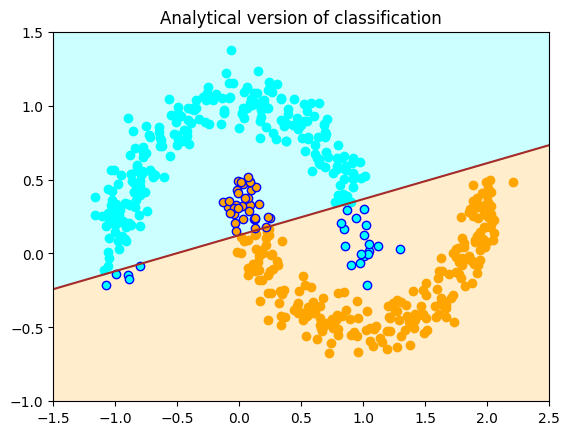

In [67]:
plot_classification_result(X_res, Theta, 'brown', 'orange', 'cyan',x, -1.5, 2.5, -1, 1.5, 'Analytical version of classification')

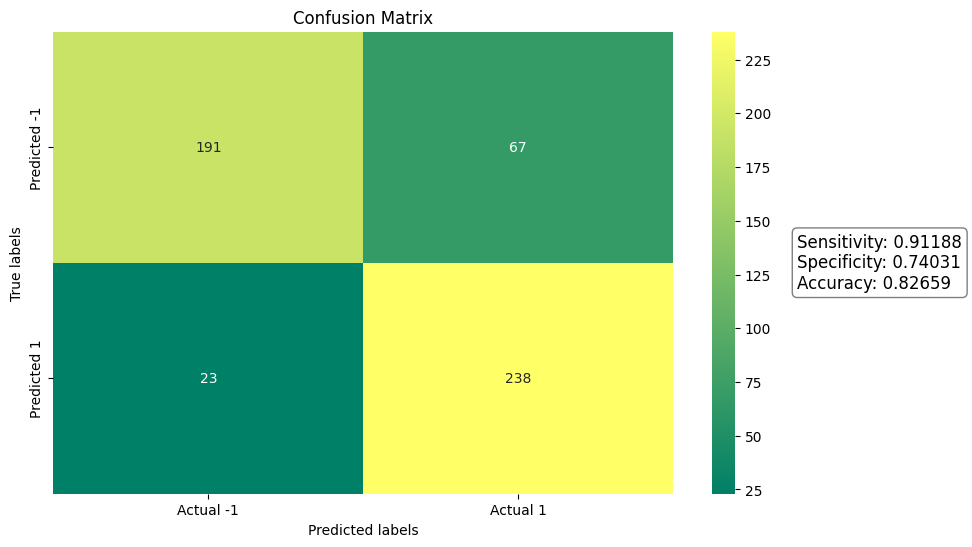

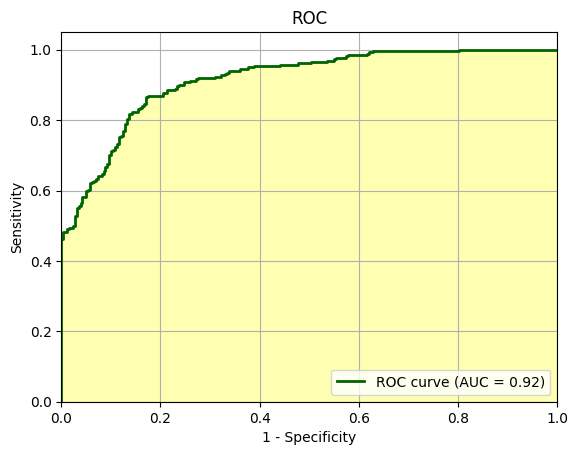

In [68]:
plot_classification_summary(true_labels, predicted_labels, 'summer')

Wyniki klasyfikacji liniowej z użyciem sklearn.linear_model.RidgeClassifier

In [69]:
X_train_clf, X_test_clf, t_train_clf, t_test_clf = train_test_split(X_clf, t_clf, test_size=0.2, random_state=random_state)
X_train_moons, X_test_moons, t_train_moons, t_test_moons = train_test_split(X_moons, t_moons, test_size=0.2, random_state=random_state)

In [70]:
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_clf, t_train_clf)

RidgeClassifier()

In [88]:
coef = ridge_classifier.coef_[0]
intercept = ridge_classifier.intercept_

Theta = np.array([-coef[0], -coef[1], -intercept[0]])
Theta

array([0.53057442, 0.20101313, 0.00625564])

In [89]:
X_test = [[X_test_clf[i][0], X_test_clf[i][1], -2*t_test_clf[i]+1] for i in range(len(X_test_clf))]
X_res = classify(Theta, X_test)
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]

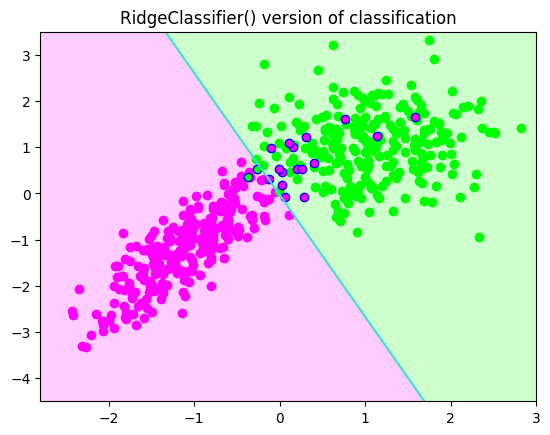

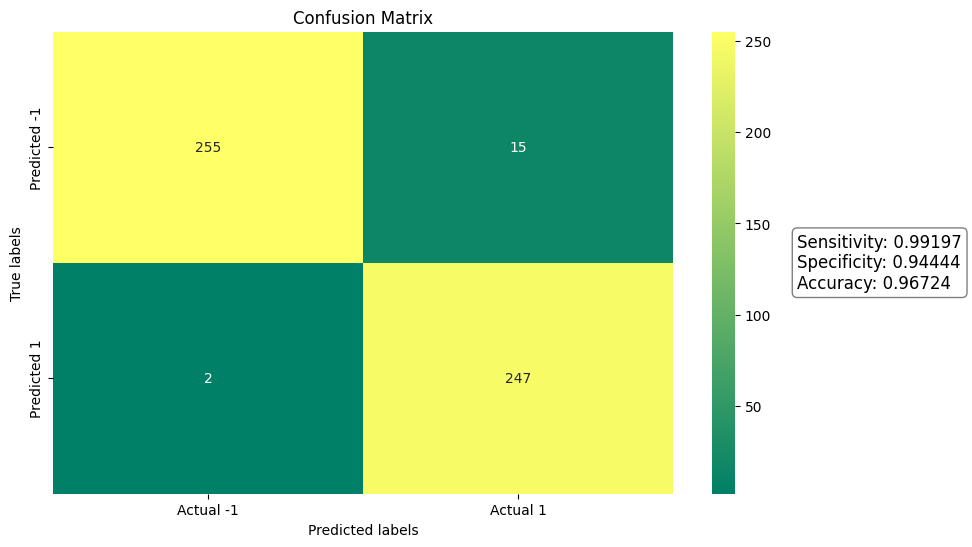

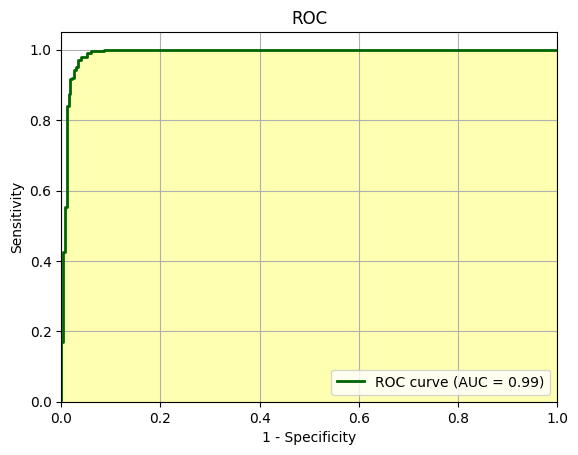

In [92]:
plot_classification_result(X_res, Theta, 'turquoise', 'magenta', 'lime', x, -2.8,3,-4.5,3.5, 'RidgeClassifier() version of classification')
plot_classification_summary(true_labels, predicted_labels, 'summer')

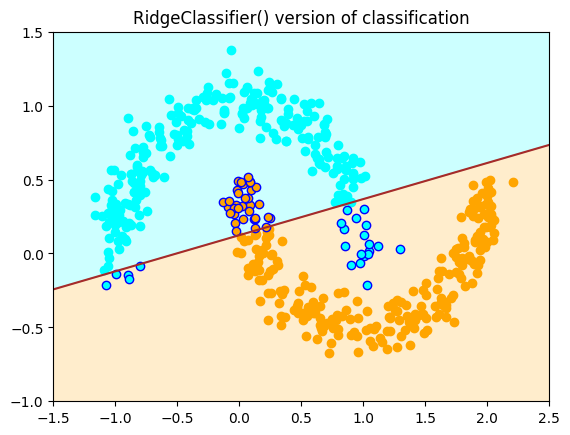

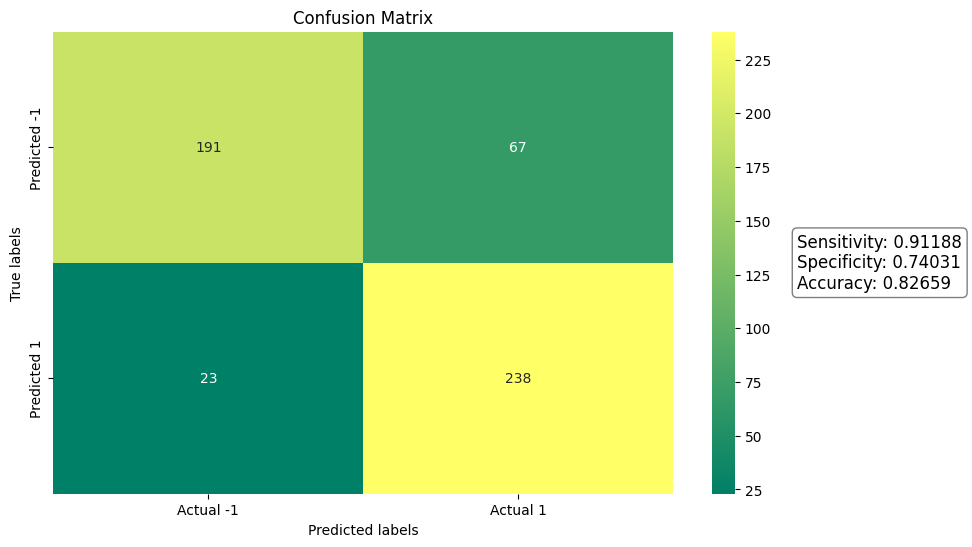

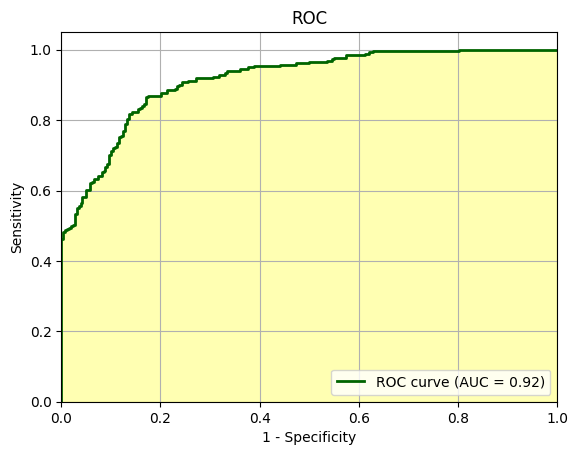

In [93]:
ridge_classifier = RidgeClassifier()
ridge_classifier.fit(X_train_moons, t_train_moons)
coef = ridge_classifier.coef_[0]
intercept = ridge_classifier.intercept_

Theta = np.array([-coef[0], -coef[1], -intercept[0]])
X_test = [[X_test_moons[i][0], X_test_moons[i][1], -2*t_test_moons[i]+1] for i in range(len(X_test_moons))]
X_res = classify(Theta, X_test)
predicted_labels = X_test@Theta.T
true_labels = [x[2] for x in X_test]
plot_classification_result(X_res, Theta, 'brown', 'orange', 'cyan',x, -1.5, 2.5, -1, 1.5, 'RidgeClassifier() version of classification')
plot_classification_summary(true_labels, predicted_labels, 'summer')